In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import mord as m
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV, StratifiedKFold, cross_val_score

## Load processed data

In [4]:
train_data = pd.read_csv('train_data_processed.csv')
test_data = pd.read_csv('test_data_processed.csv')
train_labels = np.load('train_labels.csv.npy', allow_pickle=True)
test_labels = np.load('test_labels.csv.npy', allow_pickle=True)

In [5]:
# Explains more than 80% of the variance in the data
pca = PCA(n_components=100)
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_data)
pca_train_genes = pca.fit_transform(train_scaled)

test_scaled = scaler.transform(test_data)
pca_test_genes = pca.transform(test_scaled)

all_weights = pd.DataFrame(pca.components_)
all_weights.columns = train_data.columns.values

### Figure out what this is doing

In [6]:
important_genes = []
for i in range(50):
    important_genes.append([pd.DataFrame(np.abs(all_weights)).T.nlargest(100, i).index.values])
important_genes = np.unique(important_genes, return_counts=False)

In [7]:
important_train = train_data[important_genes]
important_test = test_data[important_genes]

In [8]:
label_mapping = {'WHO II': 0, 'WHO III': 1, 'WHO IV': 2}
reverse_mapping = {0: 'WHO II', 1: 'WHO III', 2: 'WHO IV'}
mapped_labels_train = [label_mapping[x[0]] for x in train_labels]
mapped_labels_test = [label_mapping[x[0]] for x in test_labels]

# Visualize the important genes

In [9]:
def display_pca(input_data, labels, title):
    high_scaler = StandardScaler()
    input_scaled = high_scaler.fit_transform(input_data)
    
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(input_scaled)
    
    data_df = pd.DataFrame(data = transformed_data, columns = ['principal component 1', 'principal component 2'])
    class_labels_df = pd.DataFrame(labels)
    data_df = pd.concat([data_df, class_labels_df], axis = 1)
    data_df.columns = ['PC1', 'PC2', 'Grade']
    
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(1,2,1) 
    ax.set_title(title, fontsize = 15)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    targets = ['WHO II', 'WHO III', 'WHO IV']
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = data_df['Grade'] == target
        ax.scatter(data_df.loc[indicesToKeep, 'PC1']
                   , data_df.loc[indicesToKeep, 'PC2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

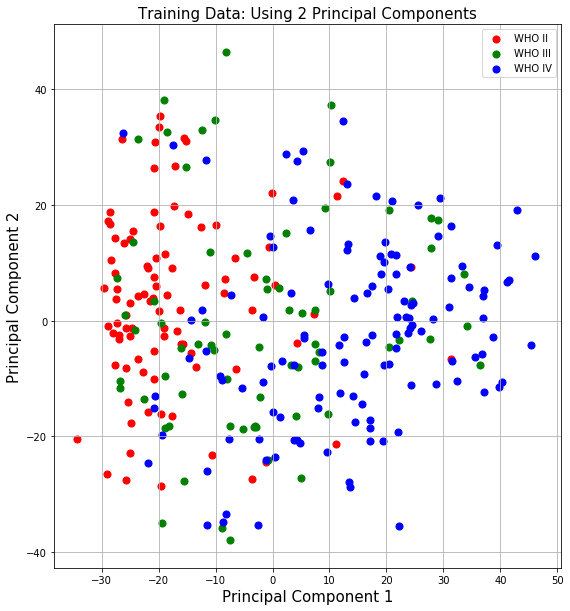

In [10]:
display_pca(important_train, train_labels, 'Training Data: Using 2 Principal Components')

## Standard Random Forest Classifier

In [54]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 15)]
max_depth = [int(x) for x in np.linspace(start = 3, stop = 20, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 1, stop = 50, num = 15)]
rf = RandomForestClassifier(bootstrap='True', random_state=0, max_features='auto')
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

In [55]:
rf_params = {'n_estimators': n_estimators, 
             'max_depth': max_depth, 
             'min_samples_split': min_samples_split}

In [56]:
rf_random_search = RandomizedSearchCV(rf, rf_params, cv=cv_strategy, n_jobs=-1, return_train_score=True)

In [58]:
rf_random_search.fit(important_train, mapped_labels_train)
rf_random_search.best_score_

0.6889655172413793

In [60]:
rf_random_search.best_params_

{'n_estimators': 600, 'min_samples_split': 11, 'max_depth': 15}

In [61]:
rf_random_search.score(important_test, mapped_labels_test)

0.696969696969697

## XGBoost Classifier
- Grid Search

In [6]:
xgb = XGBClassifier()

In [49]:
xgb.fit(important_train, mapped_labels_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [50]:
xgb.score(important_test, mapped_labels_test)

0.696969696969697

# Kernel SVM

In [47]:
important_train_scaled = scaler.fit_transform(important_train)
important_test_scaled = scaler.transform(important_test)

In [51]:
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C': np.logspace(-3, 3, 7), 'gamma': ('auto', 'scale')}
svc_grid = GridSearchCV(SVC(), parameters, cv=cv_strategy, n_jobs=-1, return_train_score=True)
svc_grid.fit(important_train_scaled, mapped_labels_train)
svc_grid.best_score_

0.6855172413793104

In [52]:
svc_grid.score(important_test_scaled, mapped_labels_test)

0.696969696969697

In [22]:
svc_grid.best_params_

{'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}

## Approximate RBF Kernel

In [112]:
x = important_train.var()
x = x.var()

In [114]:
gamma = 1/((important_train.shape[1])*x)

In [115]:
rbf = RBFSampler(gamma=gamma, n_components=100000)
X_transformed = rbf.fit_transform(important_train)

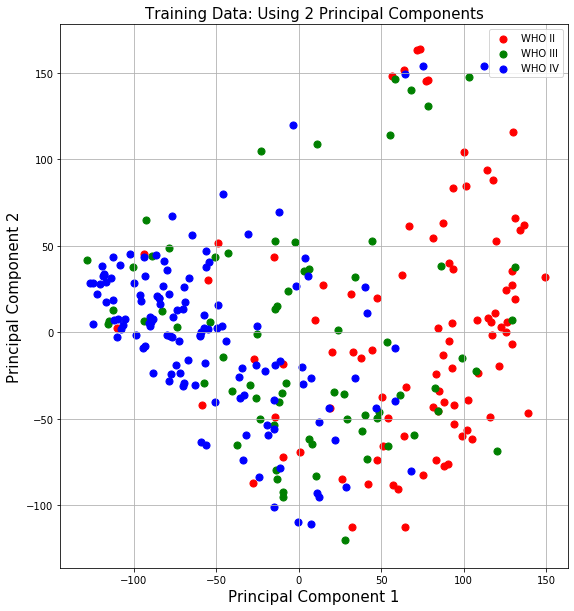

In [116]:
display_pca(X_transformed, train_labels, 'RBF Kernel')

In [117]:
c = m.LogisticIT()
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
param_grid = {'alpha': np.logspace(-3,3,7)}
ridge_grid = GridSearchCV(c, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(np.array(X_transformed), np.array(mapped_labels_train))
ridge_grid.best_score_

0.6856321839080459

## Considering the inherent order present in the classes

## Ordinal Logistic Regression
- AKA ordinal regression
- Predict a value which is ordered and also discrete 
- Seen as a generalization to binary logistic regresion
- Relies on correlated genes being removed
- Multinomial regression doesnt preserve the inherent ranking

In [69]:
c = m.LogisticIT()
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
param_grid = {'alpha': np.logspace(-3,3,7)}
ridge_grid = GridSearchCV(c, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(np.array(important_train_scaled), np.array(mapped_labels_train))
ridge_grid.best_score_

0.6919540229885057

In [70]:
ridge_grid

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             error_score=nan,
             estimator=LogisticIT(alpha=1.0, max_iter=1000, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [61]:
ridge_grid.score(np.array(important_test_scaled), np.array(mapped_labels_test))

0.7272727272727273

### To do:
- Overlapping clustering methods (something which both clusters and considers the overalapping in the data)
- Identify most important features for the best classifier
- For SVM/RBF, try MinMaxScaler compared to StandardScaler

## Feature Analysis